In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator
import pandas as pd
from importlib.metadata import version
import HePy as he
import HePy.constants as const
print('HePy version:',version('HePy'))

HePy version: 0.2.12


The fluorescence lifetime of a state is the inverse of the sum of the Einstein-A coefficients between it and every dipole allowed lower lying transition. The Einstein-A coefficients can be expressed as<br><br>
$\huge A=\frac{2e^2\omega^3}{3\epsilon_0hc^3}|D|^2$
<br><br>
Where $\omega=2\pi\nu$ is the angular frequency corresponding to the energy difference between the two states and $D$ is the transition dipoole moment. Since spontaneous emission is on average isotropic,transitions for which $\Delta m=0,\pm1$ contribute equally to the decay from each initial $|n\ell m\rangle$

I can make one basis set with all the $m_{\ell}$'s in it, but then need to calculate 3 separate sets of dipole matrix elements and transition frequencies. Then three separate sets of Einstein-A coefficients and only then can I make the end sum.

In [2]:
# Initialise a basis and calculate quantum defects - default is triplet states
nmin, nmax = 2, 22 
ns  = np.arange(nmin,nmax+1,1)
mls = [-1,0,+1] # Include all mls in one matrix
basis  = he.Basis(ns, mls)
QD_arr = he.QD_Array(basis) # array of quantum defects, index the same as basis
# basis

In [3]:
# Numerov parameters
r_exp = 1
step  = 0.0065
rcore = 0.65

# Create matrices of dipole transiton moments for each ml
Mdip0  = he.dip_matrix(basis,QD_arr, 0,r_exp,step,rcore)
Mdipm1 = he.dip_matrix(basis,QD_arr,-1,r_exp,step,rcore)
Mdipp1 = he.dip_matrix(basis,QD_arr,+1,r_exp,step,rcore)

100%|████████████████████████████████████████████████████████████████████████████████| 714/714 [00:32<00:00, 21.67it/s]


Now create a matrix of field free energies.

In [4]:
# Diagonal matrix of field free energies (Hz)
H0 = he.H_0(basis,QD_arr)
df_H0 = pd.DataFrame(H0)
# df_H0

# Check matrices are the same size
print(np.shape(Mdip0))
print(np.shape(H0))

(714, 714)
(714, 714)


Now generate matrices of Einstein-A coefficients from dipole moments and field free energies.

In [5]:
# Create Ein-A matrices for each projection
MEA0  = he.EinA_mtrx(Mdip0, H0)
MEAm1 = he.EinA_mtrx(Mdipm1,H0)
MEAp1 = he.EinA_mtrx(Mdipp1,H0)

# Add them together to make final matrix
Aeintot =  MEA0 + MEAm1 + MEAp1
df_tot  = pd.DataFrame(Aeintot)

Ok, so now all I need to do is pick a state, such as $10^3S_1$, and find the relevent Einstein-A coefficients. There are already only values for the states where $\Delta\ell=\pm1$, so all I need to do is locate the row that corresponds to the state that I care about and use these numbers.

In [6]:
# state of interest
nn, ell  = 10, 0
idx  = he.lookup_eigval(basis,nn,ell) # locate basis index of that state
Asum = df_tot.iloc[idx].sum() # sum that row of the A-coeff. matrix

print(idx)
print(basis[idx])
print(Asum)
print(1/Asum)
print('%.4f'%((1/Asum)*1e9),'ns')

116
[10, 0, 0]
1278120.8284657598
7.823986416060424e-07
782.3986 ns


# `Plot`

For $2\leq n\leq22$ calculate lifetimes of first four angular momentum states. 

In [7]:
# Initialise arrays
shr_calcs_S = []
shr_calcs_P = []
shr_calcs_D = []
shr_calcs_F = []

for n in range(len(ns[1:])):
    # state of interest
    nn, ell  = ns[1:][n], 0 # S
    idx  = he.lookup_eigval(basis,nn,ell) # locate basis index of that state
    Asum = df_tot.iloc[idx].sum() # sum that row of the A-coeff. matrix
    shr_calcs_S.append((1/Asum)*1e6) # in microseconds
    
for n in range(len(ns[:])):
    # state of interest
    nn, ell  = ns[:][n], 1 # P
    idx  = he.lookup_eigval(basis,nn,ell) 
    Asum = df_tot.iloc[idx].sum() 
    shr_calcs_P.append((1/Asum)*1e6) 
    
for n in range(len(ns[1:])):
    # state of interest
    nn, ell  = ns[1:][n], 2 # D
    idx  = he.lookup_eigval(basis,nn,ell) 
    Asum = df_tot.iloc[idx].sum() 
    shr_calcs_D.append((1/Asum)*1e6) 
    
for n in range(len(ns[2:])):
    # state of interest
    nn, ell  = ns[2:][n], 3 # F
    idx  = he.lookup_eigval(basis,nn,ell) 
    Asum = df_tot.iloc[idx].sum() 
    shr_calcs_F.append((1/Asum)*1e6) 

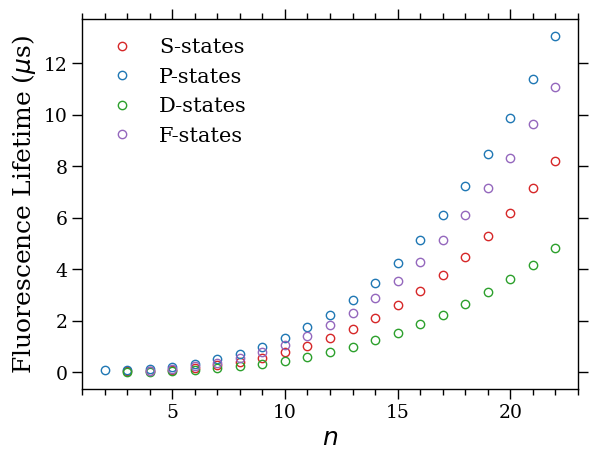

In [9]:
fig, ax = plt.subplots(1, 1,) 
fsize = 15
lnwidth = 0.5
tickwidth = 0.5
msize = 1
mpl.rc('font',family='serif')
mpl.rc('font',size=18)

nns = np.arange(2,23,1)

# Plot
plt.plot(nns[1:],shr_calcs_S,marker='o',c='none',mec='tab:red',label='S-states')
plt.plot(nns[:],shr_calcs_P,marker='o',c='none',mec='tab:blue',label='P-states')
plt.plot(nns[1:],shr_calcs_D,marker='o',c='none',mec='tab:green',label='D-states')
plt.plot(nns[2:],shr_calcs_F,marker='o',c='none',mec='tab:purple',label='F-states')

#------------------------------------------ Aesthetics ---------------------------------------------------
ax.spines['right'].set_linewidth(lnwidth*2)
ax.spines['top'].set_linewidth(lnwidth*2)
ax.spines['left'].set_linewidth(lnwidth*2)
ax.spines['bottom'].set_linewidth(lnwidth*2)
ax.tick_params(axis='both', which='major', labelsize=fsize*0.9, width = tickwidth*2, length = 7,
                direction='out', bottom=True, top=True, left=True, right=True)
ax.tick_params(axis='both', which='minor',width = tickwidth*2, length = 4,
                direction='out', bottom=True, top=True, left=True, right=True)
ax.get_yaxis().get_major_formatter().set_useOffset(False)

## Ticks
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_minor_locator(MultipleLocator(1))
# ax.yaxis.set_major_locator(MultipleLocator(20))
# ax.yaxis.set_minor_locator(MultipleLocator(5))

plt.xlabel(r'$n$')
plt.ylabel('Fluorescence Lifetime ($\mu$s)')

# Plot legend
plt.legend(loc='best',frameon=False,fontsize=fsize)

plt.show()